In [10]:
import ast
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

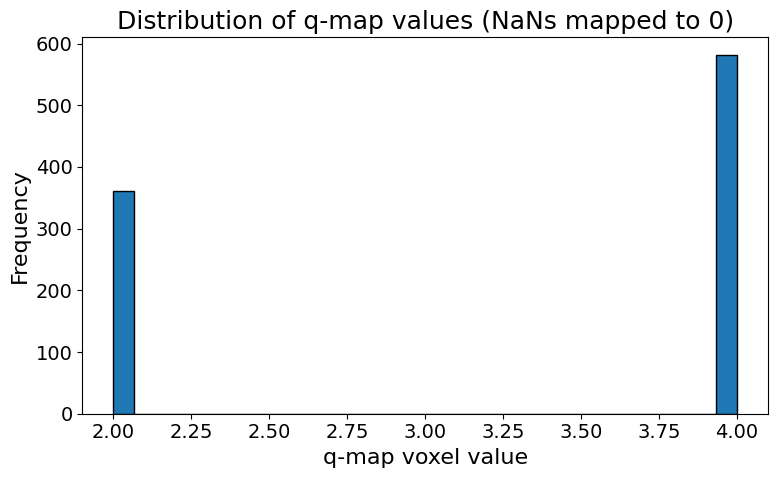

count    942.000000
mean       3.233546
std        0.972862
min        2.000000
25%        2.000000
50%        4.000000
75%        4.000000
max        4.000000
Name: qmap_value, dtype: float64


In [11]:
# ---------- CONFIG ----------
CSV_PATH = Path(r"X:\ArtifactRemovalProject\results\combined_ratings_predictions_with_qmap.csv")
OUTPUT_PATH = Path(r"X:\ArtifactRemovalProject\results\images")
# ----------------------------

# Load the CSV that already contains the qmap_value column
df = pd.read_csv(CSV_PATH)

# Replace NaNs in qmap_value with 0
qmap_series = df["qmap_value"].fillna(0.0)

# -------- Histogram of qmap values --------
plt.figure(figsize=(8, 5))
plt.hist(qmap_series, bins=30, edgecolor="black")
plt.xlabel("q-map voxel value")
plt.ylabel("Frequency")
plt.title("Distribution of q-map values (NaNs mapped to 0)")
plt.tight_layout()
plt.show()

# Display basic descriptive statistics
desc = qmap_series.describe()
print(desc)

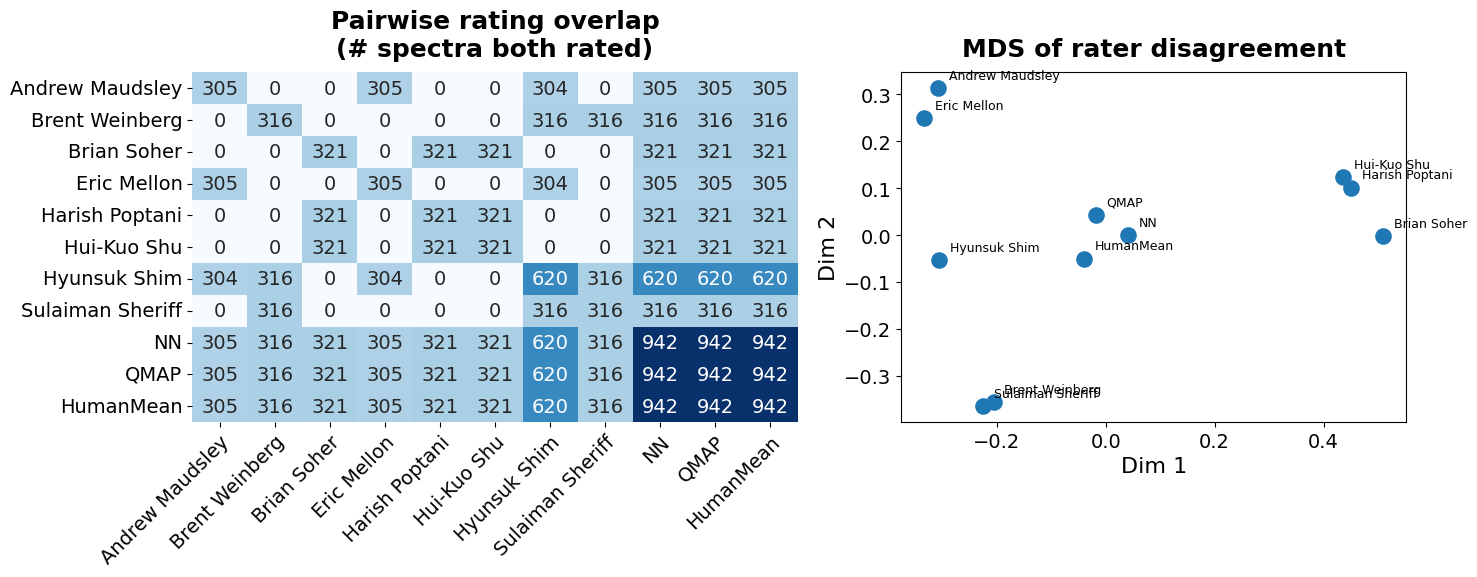

In [14]:

# 1) Load your CSV
df = pd.read_csv(r"X:\ArtifactRemovalProject\results\combined_ratings_predictions_with_qmap.csv")
df["QMAP"] = np.where(df["qmap_value"] == 4, "Acceptable",
                      np.where(df["qmap_value"].isna(), np.nan, "Unacceptable"))

# 2) Parse the list of raters in each row
df['rater_list'] = df['raters'].apply(ast.literal_eval)

# 3) Find all unique human‐rater names
all_raters = sorted({r for sub in df['rater_list'] for r in sub})

# 4) Build an empty “wide” DataFrame
wide_cols = all_raters + ["NN", "QMAP"]
wide = pd.DataFrame(index=df["unique_id"], columns=wide_cols, dtype=object)

for _, row in df.iterrows():
    # human ratings
    for name, rating in zip(row["rater_list"],
                            [row["rating_1"], row["rating_2"], row["rating_3"]]):
        wide.at[row["unique_id"], name] = rating
    # NN prediction (numeric 0/1)
    wide.at[row["unique_id"], "NN"]   = row["fits_combined_pred"]
    # QMAP prediction
    wide.at[row["unique_id"], "QMAP"] = row["QMAP"]

# ---------------------------------------------------------------------------
# 4.  ENCODE CATEGORICALLY & BUILD “HumanMean”
# ---------------------------------------------------------------------------
coded = wide.apply(lambda c: c.astype("category").cat.codes)

human_cols = all_raters                      # exclude NN & QMAP
wide_human_codes = coded[human_cols].replace(-1, np.nan)
coded["HumanMean"] = wide_human_codes.mean(axis=1)

# ---------------------------------------------------------------------------
# 5.  PAIRWISE DISTANCE MATRIX (simple disagreement rate)
# ---------------------------------------------------------------------------
names = coded.columns.tolist()               # human raters + NN + QMAP + HumanMean
n = coded.shape[1]
dist = np.zeros((n, n), float)

for i in range(n):
    for j in range(i+1, n):
        a, b = coded.iloc[:, i], coded.iloc[:, j]
        mask = (a != -1) & (b != -1)
        d = (a[mask] != b[mask]).sum() / mask.sum() if mask.any() else 1.0
        dist[i, j] = dist[j, i] = d

# replace NaNs (shouldn’t happen now) with median
dist = np.where(np.isnan(dist), np.nanmedian(dist), dist)

# ───────────────────────────────────────────────────────────────
# A)  pairwise overlap counts (n_spectra both raters labelled)
# ───────────────────────────────────────────────────────────────
names = coded.columns.tolist()           # order: human, NN, QMAP, HumanMean
n      = len(names)
overlap = np.zeros((n, n), int)

for i in range(n):
    for j in range(i, n):
        mask = (coded.iloc[:, i] != -1) & (coded.iloc[:, j] != -1)
        overlap[i, j] = overlap[j, i] = mask.sum()

# put into DataFrame for prettier labels
overlap_df = pd.DataFrame(overlap, index=names, columns=names)

# ───────────────────────────────────────────────────────────────
# B)  distance matrix → 2-D MDS (you already have this)
# ───────────────────────────────────────────────────────────────
mds_coords = MDS(n_components=2,
                 dissimilarity='precomputed',
                 random_state=42).fit_transform(dist)

# ───────────────────────────────────────────────────────────────
# C)  plot side-by-side
# ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios':[1.2,1]})

# heat-map of overlaps
sns.heatmap(overlap_df, annot=True, fmt='d',
            cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Pairwise rating overlap\n(# spectra both rated)', pad=12, fontweight='bold')
plt.setp(axes[0].get_xticklabels(),
         rotation=45,
         ha='right',            # right-align
         rotation_mode='anchor')

# MDS plot
axes[1].scatter(mds_coords[:,0], mds_coords[:,1], s=120)
for (x,y), lbl in zip(mds_coords, names):
    axes[1].text(x+0.02, y+0.02, lbl, fontsize=9)
axes[1].set_xlabel('Dim 1')
axes[1].set_ylabel('Dim 2')
axes[1].set_title('MDS of rater disagreement', pad=12, fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.show()


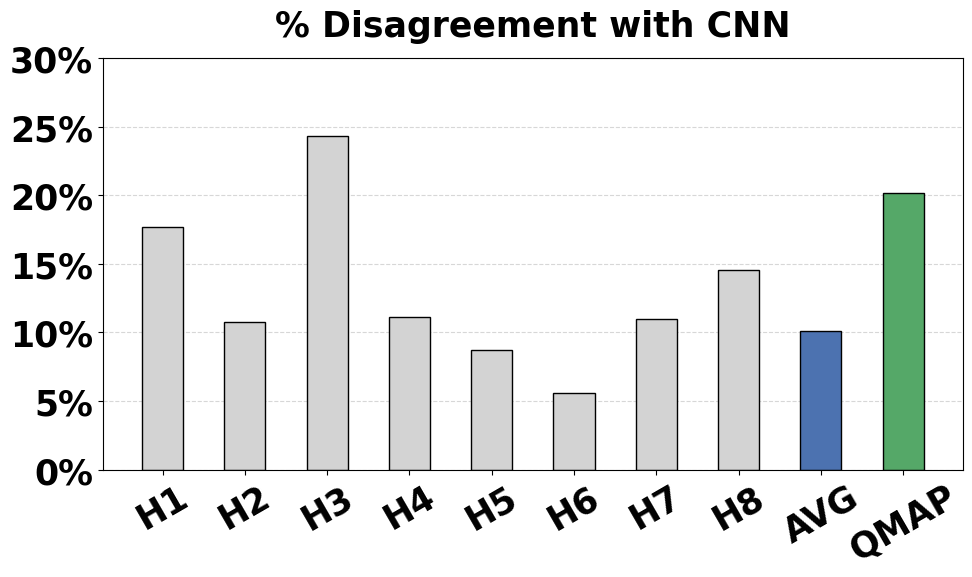

In [6]:
# 4) Compute percent disagreement vs CNN for each human rater, HumanMean, **and QMAP**
from matplotlib.ticker import FuncFormatter

percent_disagreement = {}
b = coded['NN']                          # CNN reference
for r in all_raters + ['HumanMean', 'QMAP']:
    a = coded[r]
    mask = (a != -1) & (b != -1)
    if mask.sum() > 0:
        # for HumanMean, round to nearest integer code
        a_comp = a.round().astype(int) if r == 'HumanMean' else a
        pct = 100.0 * (a_comp[mask] != b[mask]).sum() / mask.sum()
    else:
        pct = np.nan
    percent_disagreement[r] = pct

# 5) Create anonymous labels: H1…H9, Mean, QMAP, CNN
short_labels = {r: f"H{i+1}" for i, r in enumerate(all_raters)}
short_labels.update({'HumanMean': 'AVG', 'QMAP': 'QMAP', 'NN': 'CNN'})

# 6) Prepare data for plotting (omit CNN itself since it's the reference)
plot_order = all_raters + ['HumanMean', 'QMAP']
labels = [short_labels[r] for r in plot_order]
values = [percent_disagreement[r] for r in plot_order]

# Width < 1 means bars won’t butt up against each other
width = 0.6                                   # play with 0.4–0.7
# 7) Plot bar chart with styling
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels)) * 1.2              # 1.2 puts ~20 % extra gap
bars = ax.bar(x, values, width=width,
              edgecolor='black', color='lightgray')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='center')  # tilt & right-justify
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

# Highlight the Mean bar and QMAP bar
bars[ len(all_raters)   ].set_facecolor('#4C72B0')  # Mean
bars[ len(all_raters)+1 ].set_facecolor('#55A868')  # QMAP
bars[len(all_raters)].set_edgecolor('black')
bars[len(all_raters)+1].set_edgecolor('black')

# Axis labels & title
ax.set_title('% Disagreement with CNN', fontsize=25, pad=16, fontweight='bold')

# Grid and ticks
ax.set_ylim(0, 30)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# make tick labels big & bold
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontsize(25)
    lbl.set_fontweight('bold')
    
SAVE_PATH = OUTPUT_PATH / "Disagreement_vs_CNN"

plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=400)
plt.show()


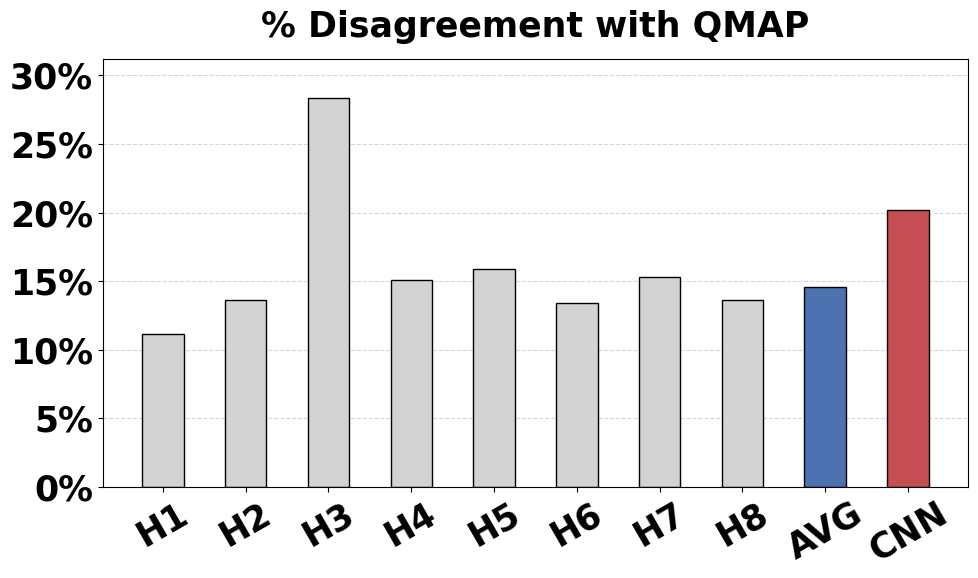

In [7]:

percent_disagreement_qmap = {}
b_q = coded['QMAP']                       # QMAP reference
for r in all_raters + ['HumanMean', 'NN']:  # compare humans + CNN to QMAP
    a = coded[r]
    mask = (a != -1) & (b_q != -1)
    if mask.sum() > 0:
        a_comp = a.round().astype(int) if r == 'HumanMean' else a
        pct = 100.0 * (a_comp[mask] != b_q[mask]).sum() / mask.sum()
    else:
        pct = np.nan
    percent_disagreement_qmap[r] = pct

# Anonymous labels (reuse the same mapping)
labels_q = [short_labels[r] for r in all_raters + ['HumanMean', 'NN']]
values_q = [percent_disagreement_qmap[r] for r in all_raters + ['HumanMean', 'NN']]

# ────────────────────────────────────────────────────────────────────────
# B) Plot the second bar chart
# ────────────────────────────────────────────────────────────────────────
# Width < 1 means bars won’t butt up against each other
# ───────────── fix: use the QMAP-specific label/value arrays ───────────
width = 0.6
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels_q)) * 1.2          # build from labels_q
bars2 = ax.bar(x, values_q, width=width,    # ← values_q here
               edgecolor='black', color='lightgray')

ax.set_xticks(x)
ax.set_xticklabels(labels_q, rotation=30, ha='center')  # ← labels_q here
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

# Highlight Mean and CNN (they are the last two bars in labels_q)
bars2[len(all_raters)].set_facecolor('#4C72B0')   # Mean
bars2[len(all_raters)+1].set_facecolor('#C44E52') # CNN
bars2[len(all_raters)].set_edgecolor('black')
bars2[len(all_raters)+1].set_edgecolor('black')

ax.set_title('% Disagreement with QMAP', fontsize=25, pad=16, fontweight='bold')
ax.set_ylim(0, max(values_q) * 1.1)

ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontsize(25)
    lbl.set_fontweight('bold')
    

SAVE_PATH = OUTPUT_PATH / "Disagreement_vs_QMAP"

plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=400)
plt.show()


  rater       chi2         p    N    p_bonf  significant
0    H1   5.640625  0.017549  305  0.157941        False
1    H2   0.927536  0.335504  316  3.019536        False
2    H3   2.526316  0.111961  321  1.007652        False
3    H4   1.890625  0.169131  305  1.522183        False
4    H5   8.491228  0.003569  321  0.032118         True
5    H6  10.105263  0.001478  321  0.013306         True
6    H7   5.082707  0.024166  620  0.217491        False
7    H8   0.057971  0.809732  316  7.287589        False
8   AVG   3.291045  0.069659  942  0.626928        False


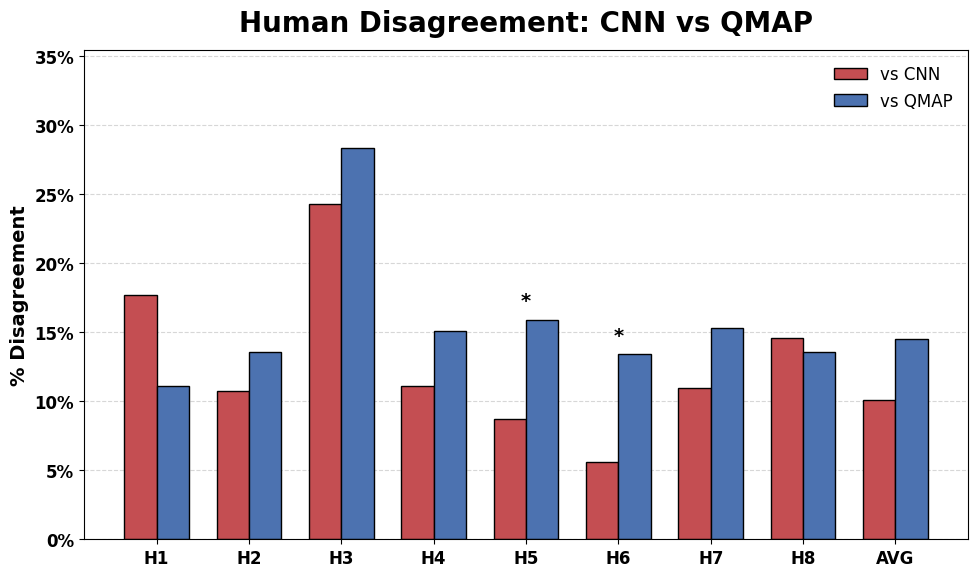

In [8]:
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd, numpy as np

alpha = 0.05                                         # family-wise error rate
raters_to_test = all_raters + ['HumanMean']          # skip NN & QMAP themselves
results = []

for r in raters_to_test:
    # only spectra where this rater, CNN, and QMAP all have labels
    a = coded[r]      ; b = coded['NN'] ; c = coded['QMAP']
    mask = (a != -1) & (b != -1) & (c != -1)
    if mask.sum() == 0:
        results.append((r, np.nan, np.nan, 0))
        continue

    d_cnn  = (a[mask] != b[mask]).astype(int)
    d_qmap = (a[mask] != c[mask]).astype(int)

    # build 2×2 table
    n00 = ((d_cnn == 0) & (d_qmap == 0)).sum()
    n01 = ((d_cnn == 0) & (d_qmap == 1)).sum()
    n10 = ((d_cnn == 1) & (d_qmap == 0)).sum()
    n11 = ((d_cnn == 1) & (d_qmap == 1)).sum()
    table = [[n00, n01],
             [n10, n11]]

    res = mcnemar(table, exact=False, correction=True)   # χ² with continuity corr
    results.append((r, res.statistic, res.pvalue, mask.sum()))

# assemble and correct for multiple tests
df_sig = pd.DataFrame(results, columns=['rater', 'chi2', 'p', 'N'])
df_sig['p_bonf'] = df_sig['p'] * len(raters_to_test)
df_sig['significant'] = df_sig['p_bonf'] < alpha

print(df_sig.replace({'rater': short_labels}))

raters = all_raters + ['HumanMean']                     # same list tested
labels = [short_labels[r] for r in raters]

vals_cnn  = [percent_disagreement[r]      for r in raters]
vals_qmap = [percent_disagreement_qmap[r] for r in raters]

# look-up dict → Bonferroni-corrected significance
sig_dict = dict(zip(df_sig['rater'], df_sig['significant']))

# ------------------ plotting ------------------
x = np.arange(len(raters))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars_cnn  = ax.bar(x - width/2, vals_cnn,  width,
                   label='vs CNN',  color='#C44E52', edgecolor='black')
bars_qmap = ax.bar(x + width/2, vals_qmap, width,
                   label='vs QMAP', color='#4C72B0', edgecolor='black')

# axes & styling
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=00, ha='center', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
ax.set_ylabel('% Disagreement', fontsize=14, fontweight='bold')
ax.set_title('Human Disagreement: CNN vs QMAP', fontsize=20, pad=14, fontweight='bold')

ax.set_ylim(0, max(np.nanmax(vals_cnn), np.nanmax(vals_qmap))*1.25)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

for t in ax.get_yticklabels():
    t.set_fontsize(12)
    t.set_fontweight('bold')

ax.legend(frameon=False, fontsize=12)

# ------------------ significance markers ------------------
for i, r in enumerate(raters):
    y_max = max(vals_cnn[i], vals_qmap[i])
    y_sig = y_max + ax.get_ylim()[1]*0.02      # a little above taller bar

    if sig_dict.get(r, False):
        marker = '*'
    else:
        marker = ''                          # non-significant

    ax.text(x[i], y_sig, marker, ha='center', va='bottom',
            fontsize=14, fontweight='bold', color='black')
    
SAVE_PATH = OUTPUT_PATH / "Disagreement_CNNQMAP_SIG"

plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=400)
plt.show()


In [ ]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import matplotlib.pyplot as plt

import pandas as pd

# 1) Load your CSV
df = pd.read_csv(r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\aggregated_spectral_ratings.csv")

# 2) Make a short “pattern” code out of the three ratings
#    (A = Acceptable, U = Unacceptable)
df['pattern'] = (
    df['rating_1'].str[0].str.upper() +
    df['rating_2'].str[0].str.upper() +
    df['rating_3'].str[0].str.upper()
)

# Method 1: get a NumPy array of unique values
unique_patterns = df['pattern'].unique()
print(unique_patterns)

# Count how many “A”s are in each pattern
a_counts = df['pattern'].str.count('A')

# Now compute each category
one_A_two_U   = (a_counts == 1).sum()   # 1 A → 2 U
two_A_one_U   = (a_counts == 2).sum()   # 2 A → 1 U
three_A       = (a_counts == 3).sum()   # 3 A → 0 U
three_U       = (a_counts == 0).sum()   # 0 A → 3 U

print(f"One A, two U : {one_A_two_U}")
print(f"Two A, one U : {two_A_one_U}")
print(f"Three A     : {three_A}")
print(f"Three U     : {three_U}")

patterns = ['A A A', 'A A U', 'U U A', 'U U U']
# counts should already be defined
counts = [three_A, two_A_one_U, one_A_two_U, three_U]
total = sum(counts)

patterns = ['A A A', 'A A U', 'U U A', 'U U U']
a_counts = df['pattern'].str.count('A')
counts = [
    (a_counts == 3).sum(),  # AAA
    (a_counts == 2).sum(),  # AAU
    (a_counts == 1).sum(),  # UUA
    (a_counts == 0).sum(),  # UUU
]
total = sum(counts)

# Build summary DataFrame
summary_df = pd.DataFrame({
    'Pattern': patterns,
    'Count': counts,
    'Percentage': [f"{cnt/total*100:.2f}%" for cnt in counts]
})

# Display to user
summary_df


# ─── Render as a Matplotlib table ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # hide axes

# draw table
tbl = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)

# styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 1.5)                # stretch rows a bit for readability


plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import matplotlib.pyplot as plt

import pandas as pd

# 1) Load your CSV
df = pd.read_csv(r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\aggregated_spectral_ratings.csv")

# 2) Make a short “pattern” code out of the three ratings
#    (A = Acceptable, U = Unacceptable)
df['pattern'] = (
    df['rating_1'].str[0].str.upper() +
    df['rating_2'].str[0].str.upper() +
    df['rating_3'].str[0].str.upper()
)

# Method 1: get a NumPy array of unique values
unique_patterns = df['pattern'].unique()
print(unique_patterns)

# Count how many “A”s are in each pattern
a_counts = df['pattern'].str.count('A')

# Now compute each category
one_A_two_U   = (a_counts == 1).sum()   # 1 A → 2 U
two_A_one_U   = (a_counts == 2).sum()   # 2 A → 1 U
three_A       = (a_counts == 3).sum()   # 3 A → 0 U
three_U       = (a_counts == 0).sum()   # 0 A → 3 U

print(f"One A, two U : {one_A_two_U}")
print(f"Two A, one U : {two_A_one_U}")
print(f"Three A     : {three_A}")
print(f"Three U     : {three_U}")

patterns = ['A A A', 'A A U', 'U U A', 'U U U']
# counts should already be defined
counts = [three_A, two_A_one_U, one_A_two_U, three_U]
total = sum(counts)
print (f"Total: {total}")

offset = max(counts) * 0.01  # 1% of the max, tweak as needed

fig, ax = plt.subplots(figsize=(9,4))
bars = ax.barh(
    patterns,
    counts,
    color='lightgray',
    edgecolor='black',
    linewidth=1
)

# remove the y-ticks (we'll draw our own labels)
ax.set_yticks([])

# annotate each bar: "A A A (xx.x%)"
for bar, pat, cnt in zip(bars, patterns, counts):
    pct = cnt / total * 100
    ax.text(
        cnt + offset,
        bar.get_y() + bar.get_height() / 2,
        f"{pat} \n ({pct:.1f}%)",
        va='center',
        fontweight='bold',
        fontsize=17
    )

# x-axis limits & ticks every 1000 formatted as "0k", "1k", …
ax.set_xlim(0, 4550)
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))

# Increase font size of the x-ticks
ax.tick_params(axis='x', labelsize=16)           # <-- make labels bigger
for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')    

# bold spines & ticks
for spine in ax.spines.values():
    spine.set_linewidth(1)
ax.tick_params(axis='both', which='major', width=1, labelsize=15)

ax.set_xlabel('Number of Spectra', fontweight='bold', fontsize=17)

plt.tight_layout()

plt.savefig('ratersexpert', dpi = 400)
plt.show()


